In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, EarlyStoppingCallback
from transformers import DataCollatorForSeq2Seq
from huggingface_hub import HfFolder
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import load_dataset
from datasets import concatenate_datasets
from transformers import T5ForConditionalGeneration, T5Tokenizer
from transformers import GenerationConfig
from random import randrange
import evaluate
import nltk
import numpy as np
from nltk.tokenize import sent_tokenize
from collections import Counter
nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/risto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# !pip install nltk

In [3]:
# !pip install evaluate

In [4]:
# !pip install rouge_score

In [5]:
# !pip install py7zr

In [6]:
# !pip install peft

In [7]:
# !pip install transformers --upgrade

source: https://towardsdatascience.com/how-to-adapt-a-multilingual-t5-model-for-a-single-language-b9f94f3d9c90

## model

In [2]:
model_id="google/mt5-base"
tokenizer = T5Tokenizer.from_pretrained(model_id)
model = T5ForConditionalGeneration.from_pretrained(model_id)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.


In [6]:
def msize(m):
    return sum(p.numel() for p in m.parameters())
print(msize(model.shared) / msize(model))   
print(msize(model.lm_head) / msize(model))  

0.32981729710484153
0.32981729710484153


## data

In [2]:
dataset_id = "TalTechNLP/samsum_ee"

dataset = load_dataset(dataset_id)

print(f"Train dataset size: {len(dataset['train'])}")
print(f"Test dataset size: {len(dataset['test'])}")

Train dataset size: 14732
Test dataset size: 819


In [3]:
train_dataset = dataset['train'].filter(lambda example, idx: example['summary'] is not None and example['dialogue'] is not None, with_indices=True)
train_dataset

Dataset({
    features: ['id', 'dialogue', 'summary', 'en_dialogue', 'en_summary'],
    num_rows: 13199
})

In [4]:
test_dataset = dataset['test'].filter(lambda example, idx: example['summary'] is not None and example['dialogue'] is not None, with_indices=True)
test_dataset

Dataset({
    features: ['id', 'dialogue', 'summary', 'en_dialogue', 'en_summary'],
    num_rows: 809
})

## update model vocabulary

In [13]:
texts4vocab=train_dataset['dialogue']+train_dataset['summary']
len(texts4vocab)

26398

In [14]:
cnt_et = Counter()
for text in texts4vocab:
    cnt_et.update(tokenizer.encode(text))
print(len(cnt_et), len(cnt_et)/tokenizer.vocab_size)  

22815 0.0912235105957617


In [15]:
cnt_et.most_common(20)

[(259, 222378),
 (267, 152951),
 (260, 109486),
 (261, 103717),
 (351, 37623),
 (291, 35910),
 (262, 29563),
 (1, 26398),
 (263, 24319),
 (432, 24040),
 (265, 23799),
 (309, 21963),
 (266, 21379),
 (383, 20708),
 (327, 19689),
 (316, 18386),
 (1055, 17737),
 (496, 17714),
 (1221, 15946),
 (178005, 14920)]

In [16]:
new_tokens = set(range(1000))
for i, (k, v) in enumerate(cnt_et.items()):
    if k not in new_tokens:
        new_tokens.add(k)
for t in range(tokenizer.vocab_size - 100, tokenizer.vocab_size):
    new_tokens.add(t)
print(len(new_tokens))
kept_ids = sorted(new_tokens)

23422


In [17]:
kept_ids[-10:]

[250090,
 250091,
 250092,
 250093,
 250094,
 250095,
 250096,
 250097,
 250098,
 250099]

### update model

In [18]:
new_size = len(kept_ids)
new_emb = torch.nn.Embedding(new_size, model.shared.embedding_dim)
new_head = torch.nn.Linear(in_features=model.lm_head.in_features, out_features=new_size, bias=False)
for new_id, old_id in enumerate(kept_ids):
    new_emb.weight.data[new_id] = model.shared.weight.data[old_id]
    new_head.weight.data[new_id] = model.lm_head.weight.data[old_id]
model.shared.weight = new_emb.weight
model.lm_head.weight = new_head.weight
model.config.__dict__['vocab_size'] = new_size
model.config.__dict__['_name_or_path'] = 'mt5_et_base/mt_et_t5-base'

### update tokenizer

In [3]:
# !apt-get update 
# !apt install protobuf-compiler -y

In [21]:
! wget https://raw.githubusercontent.com/google/sentencepiece/master/src/sentencepiece_model.proto
! protoc --python_out=. sentencepiece_model.proto
import sentencepiece.sentencepiece_model_pb2 as spmp
smp = tokenizer.sp_model.serialized_model_proto()
m = spmp.ModelProto()
m.ParseFromString(smp)
print('the loaded model has pieces:', len(m.pieces))
new_pieces = [m.pieces[idx] for idx in kept_ids]
print('the new pieces:', len(new_pieces))
# replace the content of the first 30K pieces
for i, p in enumerate(new_pieces):
    m.pieces[i].piece = p.piece
    m.pieces[i].score = p.score
    m.pieces[i].type = p.type
# drop the remaining pieces
n = len(new_pieces)
for i in range(len(m.pieces) - n):
    m.pieces.pop(len(m.pieces) - 1)
print(len(m.pieces))
with open('mt5_et_base/new_sp.model', 'wb') as f:
    f.write(m.SerializeToString())
new_tokenizer = T5Tokenizer('mt5_et_base/new_sp.model', extra_ids=0)

--2024-04-09 07:02:03--  https://raw.githubusercontent.com/google/sentencepiece/master/src/sentencepiece_model.proto
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14023 (14K) [text/plain]
Saving to: ‘sentencepiece_model.proto.1’

sentencepiece_model 100%[===================>]  13.69K  --.-KB/s    in 0.001s  

2024-04-09 07:02:03 (13.9 MB/s) - ‘sentencepiece_model.proto.1’ saved [14023/14023]

the loaded model has pieces: 250100
the new pieces: 23422
23422


In [22]:
new_tokenizer.save_pretrained('mt5_et_base')
model.save_pretrained('mt5_et_base')

In [5]:
tokenizer = T5Tokenizer.from_pretrained('mt5_et_base')
model = T5ForConditionalGeneration.from_pretrained('mt5_et_base', max_length=512)

## prep data for training

In [16]:
max_source_length=1024

In [17]:
max_target_length=512

In [21]:
def preprocess_function(sample,padding="max_length"):
    # add prefix to the input for t5
    inputs = ["summarize: " + item for item in sample["dialogue"]]

    # tokenize inputs
    model_inputs = tokenizer(inputs, max_length=max_source_length, padding=padding, truncation=True)

    # Tokenize targets with the `text_target` keyword argument
    labels = tokenizer(text=sample["summary"], max_length=max_target_length, padding=padding, truncation=True)

    # If we are padding here, replace all tokenizer.pad_token_id in the labels by -100 when we want to ignore
    # padding in the loss.
    if padding == "max_length":
        labels["input_ids"] = [
            [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
        ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=["dialogue", "summary", "id"])
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True, remove_columns=["dialogue", "summary", "id"])

## evaluator

In [6]:
# Metric
metric = evaluate.load("rouge")

# helper function to postprocess text
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(sent_tokenize(label)) for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    result = {k: round(v * 100, 4) for k, v in result.items()}
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    return result

In [23]:
# we want to ignore tokenizer pad token in the loss
label_pad_token_id = -100
# Data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=label_pad_token_id,
    pad_to_multiple_of=8
)

## training 

In [27]:
early_stop = EarlyStoppingCallback(3, 0.0)

In [28]:
# Hugging Face repository id
repository_id = f"{model_id.split('/')[1]}-{dataset_id}"#for some reason this was not working

# Define training args
training_args = Seq2SeqTrainingArguments(
    output_dir=repository_id,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    predict_with_generate=True,
    fp16=False, # Overflows with fp16
    learning_rate=5e-5,
    num_train_epochs=20,
    # logging & evaluation strategies
    logging_dir=f"{repository_id}/logs",
    logging_strategy="steps",
    logging_steps=500,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    # push to hub parameters
    report_to="tensorboard",
    push_to_hub=False,
    hub_strategy="every_save",
    hub_model_id=repository_id,
    hub_token=HfFolder.get_token(),
    # generation_max_length=40
)

# Create Trainer instance
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stop]
)

/home/risto/.local/lib/python3.9/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [29]:
# Start training
trainer.train(resume_from_checkpoint=True)

There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
11,1.476000,1.785272,37.760800,16.082000,32.072500,34.882500,28.505562
12,1.467900,1.799523,38.610600,16.408700,32.740200,35.717700,29.309023
13,1.395700,1.797791,38.167500,16.068800,32.491300,35.198500,28.166873


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


TrainOutput(global_step=42900, training_loss=0.334581650242661, metrics={'train_runtime': 7668.7277, 'train_samples_per_second': 34.423, 'train_steps_per_second': 8.606, 'total_flos': 2.2794211507883213e+17, 'train_loss': 0.334581650242661, 'epoch': 13.0})

## calculate metrics

In [7]:
model_id='mt5-base-TalTechNLP/samsum_ee/checkpoint-26400/'
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

In [8]:
model=model.to('cuda')

In [9]:
def calc_texts_labels_metrics(texts, summaries, model, tokenizer, max_input_length=1024, max_output_length=512, batch_size = 10, temperature=0):
    true_labels=tokenizer(
        summaries, return_tensors="pt",padding="max_length", truncation=True, max_length=max_input_length
    ).input_ids.cpu()
    input_ids = tokenizer(
        texts, return_tensors="pt", padding="max_length", truncation=True, max_length=max_input_length
    ).input_ids  
    
    predictions = []
    for i in range(0, input_ids.size(0), batch_size):
        batch_input_ids = input_ids[i:i + batch_size].to('cuda')
        batch_outputs = model.generate(input_ids=batch_input_ids, max_length=max_output_length, temperature=temperature)
        predictions.extend(batch_outputs.cpu().detach().numpy())
    max_length = max(len(p) for p in predictions)
    padded_predictions = [np.pad(p, (0, max_length - len(p)), mode='constant') for p in predictions]
    outputs = torch.tensor(padded_predictions)
    eval_preds = (outputs, true_labels.cpu())
    metrics = compute_metrics(eval_preds)
    return metrics

In [10]:
eval_metrics=calc_texts_labels_metrics(test_dataset['dialogue'], test_dataset['summary'], model, tokenizer)
eval_metrics

/home/risto/.local/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/tmp/ipykernel_40399/1402398918.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  outputs = torch.tensor(padded_predictions)


{'rouge1': 37.7457,
 'rouge2': 15.6536,
 'rougeL': 31.659,
 'rougeLsum': 34.5857,
 'gen_len': 31.359703337453645}

## example usage

In [15]:
def summarize(text, model, tokenizer, max_input_length=1024, max_new_tokens=512):
    input_ids = tokenizer(
         text, return_tensors="pt",
        max_length=max_input_length
    ).input_ids  # Batch size 1
    outputs = model.generate(input_ids=input_ids.to('cuda'), max_new_tokens=max_new_tokens)
    print(tokenizer.decode(outputs[0], skip_special_tokens=True))

In [18]:
summarize(dataset['test'][0]['dialogue'], model, tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Amanda otsib Betty telefoninumbrit. Larry helistas Bettyle viimati, kui nad koos pargis käisid. Amanda saadab Bettyle sõnumi.


In [19]:
dataset['test'][0]['summary']

'Hannah vajab Betty telefoninumbrit, kuid Amandal seda pole. Ta peab Larryga ühendust võtma.'

In [20]:
summarize(dataset['test'][1]['dialogue'], model, tokenizer)

Eric ja Rob vaatavad etendust, mille Eric talle saatis.


In [22]:
dataset['test'][1]['dialogue']

"Eric: MASIN!\nRob: See on nii lahe!\nEric: Ma tean! Ja näitab, kuidas ameeriklased näevad venelasi ;)\nRob: Ja see on tõesti naljakas!\nEric: Ma tean! Mulle meeldib eriti rongi osa!\nRob: Hahaha! Keegi ei räägi masinaga nii!\nEric: Kas see on tema ainus etendus?\nRob: Ei tea. Ma vaatan järele.\nEric: Kindlasti.\nRob: Selgub, et ei! Mõned tema etendused on Youtube'is.\nEric: Lahe! Ma vaatan neid kohe!\nRob: Mina ka!\nEric: MASIN!\nRob: MASIN!\nEric: Kuni kohtumiseni?\nRob: Muidugi :)"

In [21]:
dataset['test'][1]['summary']

"Eric ja Rob lähevad vaatama stand-up'i YouTube'is."

In [23]:
summarize(dataset['test'][2]['dialogue'], model, tokenizer)

Bob aitab Lennyl valida kleidi, mida ta peaks valima. Lenny ostab esimese paari, kuid ta eelistab lillad püksid.


In [24]:
dataset['test'][2]['dialogue']

'Lenny: Kallis, kas sa saaksid mulle millegagi abi anda?\nBob: Muidugi, mis toimub?\nLenny: Millise ma peaksin valima?\nBob: Saada mulle pilte.\nLenny: <file_photo>\nLenny: <file_photo>\nLenny: <file_photo>\nBob: Mulle meeldivad kõige rohkem esimesed.\nLenny: Aga mul on juba lillad püksid. Kas on mõtet omada kahte paari?\nBob: Mul on neli musta paari :D :D\nLenny: Jah, aga kas ma ei peaks valima erinevat värvi?\nBob: Oluline on see, milline annab sulle kõige rohkem riietumisvõimalusi.\nLenny: Nii et ma arvan, et ostan esimese või kolmanda paari siis.\nBob: Vali parim kvaliteet siis.\nLenny: Sul on õigus, aitäh.\nBob: Pole probleemi :)'

In [25]:
dataset['test'][2]['summary']

'Lenny ei suuda otsustada, millised püksid osta. Bob nõustas Lennyt selles küsimuses. Lenny läheb Bobi nõu järgi ja valib kvaliteetseimad püksid.'

In [26]:
summarize(dataset['test'][3]['dialogue'], model, tokenizer)

Emma tuleb varsti koju, et süüa toitu. Will tuleb Emma järele varsti.


In [28]:
dataset['test'][3]['dialogue']

'Will: hei kallis, mida sa täna õhtuks süüa tahad?\nEmma: oh, ära täna üldse muretse selle pärast\nWill: mida sa selle all mõtled? kas kõik on korras?\nEmma: mitte päris, aga see on ok, ära muretse toiduvalmistamise pärast, mul pole isu\nWill: millal sa koju jõuad?\nEmma: varsti, loodetavasti\nWill: kas sa oled kindel? võib-olla tahad, et ma sind järele tuleksin?\nEmma: ei ei, see on korras. Ma jõuan varsti koju, ma ütlen sulle, kui ma koju jõuan.\nWill: Selge, armastan sind.\nEmma: armastan sind ka.'

In [29]:
dataset['test'][3]['summary']

'Emma tuleb varsti koju ja ta annab Willile teada.'

In [30]:
summarize("studies have shown that owning a dog is good for you", model, tokenizer)

Täna on studies avastanud, et oaping a dog is good for you.


In [31]:
input_text="""Veel veebruaris oli Soome kõige populaarsem partei Koonderakond, kuid kaotas märtsis selle tiitli SDP-le. Märtsis langes peaministripartei  toetus ühe protsendi võrra ning Koonderakonna toetus on nüüd 20,6 protsenti.
SDP suurendas toetust naiste ja noorte hulgas. Märtsis tõusis SDP toetus 1,9 protsenti ning erakonna toetus on nüüd 21,7 protsenti. 
Koonderakonna kannul on Põlissoomlased, rahandusminister Riikka Purra kodupartei toetus on 17,4 protsenti."""
summarize(input_text, model, tokenizer)

Koonderakond kaotas märtsis tiitli SDP-le. Koonderakond kaotas märtsis tiitli SDP-le. Koonderakonna kannul on Põlissoomlased, rahandusminister Riikka Purra kodupartei toetus on nüüd 37,5 protsenti.


## visualize logs

In [50]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

# Path to your TensorBoard log files
log_path = 'mt5-base-TalTechNLP/samsum_ee/logs/events.out.tfevents.1712648953.2ca00bef5a11.4724.0'
log_path2 = 'mt5-base-TalTechNLP/samsum_ee/logs/events.out.tfevents.1712678708.2ca00bef5a11.4724.1'

In [53]:
def load_tensorboard_data(event_file_path):
    # Initialize an EventAccumulator with size_guidance for auto loading of all data
    ea = event_accumulator.EventAccumulator(event_file_path,
        size_guidance={
            event_accumulator.SCALARS: 0,
            event_accumulator.IMAGES: 0,
            event_accumulator.AUDIO: 0,
            event_accumulator.HISTOGRAMS: 0,
            event_accumulator.TENSORS: 0,
        })

    # Load the data
    ea.Reload()

    # Data extraction examples
    data = {}

    # Extract scalars to a DataFrame
    for tag in ea.Tags()['scalars']:
        events = ea.Scalars(tag)
        data[tag] = pd.DataFrame([(e.step, e.value) for e in events], columns=['Step', tag])

    # Extend this part to handle histograms, images, etc., as needed

    return data

data = load_tensorboard_data(log_path)
data_second=load_tensorboard_data(log_path2)
# Example to print the available scalar tags and their first few values
for tag, df in data.items():
    print(f"Data for tag: {tag}")
    # print(df.head())
    
df

Data for tag: train/loss
Data for tag: train/learning_rate
Data for tag: train/epoch
Data for tag: eval/loss
Data for tag: eval/rouge1
Data for tag: eval/rouge2
Data for tag: eval/rougeL
Data for tag: eval/rougeLsum
Data for tag: eval/gen_len
Data for tag: eval/runtime
Data for tag: eval/samples_per_second
Data for tag: eval/steps_per_second
Data for tag: train/train_runtime
Data for tag: train/train_samples_per_second
Data for tag: train/train_steps_per_second
Data for tag: train/total_flos
Data for tag: train/train_loss


,Step,train/train_loss
0,33000,1.972961


<AxesSubplot:>

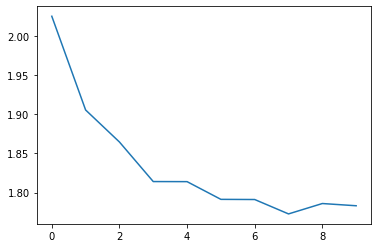

In [54]:
data['eval/loss']['eval/loss'].plot()

<AxesSubplot:>

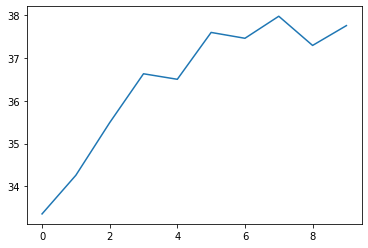

In [55]:
data['eval/rouge1']['eval/rouge1'].plot()

In [57]:
data['eval/rouge1']['eval/rouge1'].max()

37.971500396728516

<AxesSubplot:>

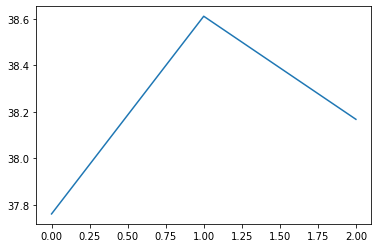

In [56]:
data_second['eval/rouge1']['eval/rouge1'].plot()

In [58]:
data_second['eval/rouge1']['eval/rouge1'].max()

38.610599517822266

<AxesSubplot:>

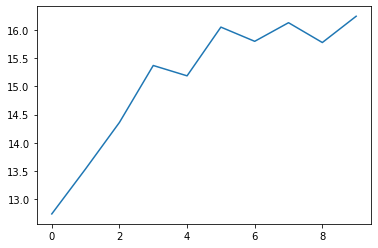

In [76]:
data['eval/rouge2']['eval/rouge2'].plot()

<AxesSubplot:>

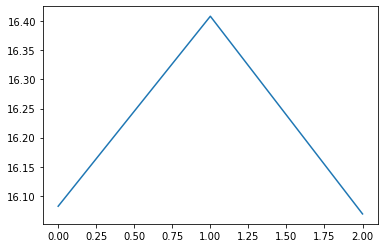

In [77]:
data_second['eval/rouge2']['eval/rouge2'].plot()